In [2]:
import pandas as pd
import numpy as np

import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [4]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

tokens = tokenize(text)

In [5]:
tokens

['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms',
 'that',
 'improve',
 'automatically',
 'through',
 'experience',
 'it',
 'is',
 'seen',
 'as',
 'a',
 'subset',
 'of',
 'artificial',
 'intelligence',
 'machine',
 'learning',
 'algorithms',
 'build',
 'a',
 'mathematical',
 'model',
 'based',
 'on',
 'sample',
 'data',
 'known',
 'as',
 'training',
 'data',
 'in',
 'order',
 'to',
 'make',
 'predictions',
 'or',
 'decisions',
 'without',
 'being',
 'explicitly',
 'programmed',
 'to',
 'do',
 'so',
 'machine',
 'learning',
 'algorithms',
 'are',
 'used',
 'in',
 'a',
 'wide',
 'variety',
 'of',
 'applications',
 'such',
 'as',
 'email',
 'filtering',
 'and',
 'computer',
 'vision',
 'where',
 'it',
 'is',
 'difficult',
 'or',
 'infeasible',
 'to',
 'develop',
 'conventional',
 'algorithms',
 'to',
 'perform',
 'the',
 'needed',
 'tasks']

In [6]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

word_to_id, id_to_word = mapping(tokens)
word_to_id

{'explicitly': 0,
 'automatically': 1,
 'difficult': 2,
 'that': 3,
 'intelligence': 4,
 'subset': 5,
 'predictions': 6,
 'do': 7,
 'variety': 8,
 'vision': 9,
 'experience': 10,
 'infeasible': 11,
 'so': 12,
 'perform': 13,
 'algorithms': 14,
 'applications': 15,
 'email': 16,
 'as': 17,
 'filtering': 18,
 'are': 19,
 'tasks': 20,
 'order': 21,
 'make': 22,
 'of': 23,
 'artificial': 24,
 'machine': 25,
 'model': 26,
 'decisions': 27,
 'seen': 28,
 'sample': 29,
 'and': 30,
 'needed': 31,
 'to': 32,
 'through': 33,
 'such': 34,
 'used': 35,
 'build': 36,
 'on': 37,
 'wide': 38,
 'or': 39,
 'being': 40,
 'mathematical': 41,
 'in': 42,
 'develop': 43,
 'computer': 44,
 'where': 45,
 'programmed': 46,
 'a': 47,
 'known': 48,
 'the': 49,
 'based': 50,
 'study': 51,
 'without': 52,
 'conventional': 53,
 'it': 54,
 'data': 55,
 'training': 56,
 'is': 57,
 'improve': 58,
 'learning': 59}

In [7]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [8]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [9]:
X.shape, y.shape

((330, 60), (330, 60))

In [10]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

model = init_network(len(word_to_id), 10)

In [11]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [12]:
(X @ model["w1"]).shape

(330, 10)

In [13]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

In [14]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

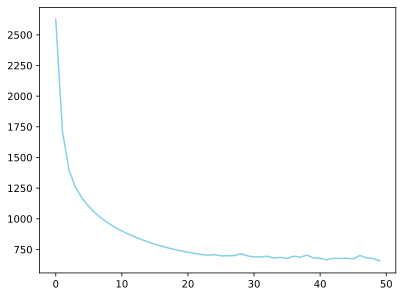

In [18]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [22]:
np.argsort(result)[::-1]

array([25, 14, 12,  4, 36, 19, 49, 59, 57, 17, 35, 24, 41, 47, 33,  1, 18,
        5, 31, 43, 28, 46, 26, 58, 10, 15, 23, 16, 39, 38, 42,  9, 30, 45,
        2, 21,  8, 34, 53,  7,  3,  6, 52, 56, 29, 44, 50, 54, 48,  0, 51,
       13, 37, 27, 40, 55, 11, 20, 32, 22])

In [19]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
algorithms
so
intelligence
build
are
the
learning
is
as
used
artificial
mathematical
a
through
automatically
filtering
subset
needed
develop
seen
programmed
model
improve
experience
applications
of
email
or
wide
in
vision
and
where
difficult
order
variety
such
conventional
do
that
predictions
without
training
sample
computer
based
it
known
explicitly
study
perform
on
decisions
being
data
infeasible
tasks
to
make


In [24]:
result[25]

np.float64(0.29582116133017117)

In [25]:
result

array([6.80477110e-05, 4.61864325e-03, 3.83704699e-04, 2.07911805e-04,
       7.18246402e-02, 4.07302557e-03, 1.92015884e-04, 2.49852437e-04,
       2.66819482e-04, 4.16092845e-04, 1.31920410e-03, 1.77060038e-05,
       7.33802305e-02, 4.21584682e-05, 2.26709069e-01, 1.24594103e-03,
       6.82850252e-04, 1.91419889e-02, 4.16105367e-03, 5.38930751e-02,
       1.12387808e-05, 3.48777844e-04, 1.72109059e-06, 7.78623706e-04,
       8.22217254e-03, 2.95821161e-01, 1.43104951e-03, 3.26081413e-05,
       2.40330472e-03, 1.54770463e-04, 4.13768435e-04, 3.04173060e-03,
       2.34687437e-06, 4.84949279e-03, 2.66669990e-04, 1.00303022e-02,
       6.53247290e-02, 3.35813100e-05, 5.78596621e-04, 5.89869758e-04,
       1.99307747e-05, 7.81684793e-03, 4.97965181e-04, 2.83299819e-03,
       1.27731322e-04, 3.94227825e-04, 1.80229345e-03, 5.27703447e-03,
       8.49958894e-05, 5.02756146e-02, 1.20938401e-04, 6.28338429e-05,
       1.87907938e-04, 2.51926785e-04, 1.19950494e-04, 1.84992936e-05,
      

In [26]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [27]:
get_embedding(model, "machine")

array([ 0.33071547, -0.03585247,  2.48630572, -1.3915161 , -1.08666401,
        0.61945402,  1.10926603, -0.01158628, -0.16868314,  0.69904055])